# Portfolio Optimization

We are given a set of $n$ assets $\{1, 2, ..., n\}$ with
- Expected returns: $\mu_i$
- Coveriances: $\sigma_{ij}$

We want to minimize the following cost function
$$C(\{x_i\}) = - \sum_i \mu_i x_i  + q\sum_{ij} \sigma_{ij} x_i x_j$$
where $x_i \in \{0, 1\}$ and $q$ is the risk factor.

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp
from qiskit.primitives import StatevectorEstimator, StatevectorSampler
from scipy.optimize import minimize

from qiskit_finance.data_providers import *
from datetime import datetime
import matplotlib.pyplot as plt

## View the Data
We will use randomly generated data using `RandomDataProvider`.
The number of assets `num_assets` will equal the number of qubits required in the quantum computation.

In [2]:
num_assets = 4

# Generate expected return and covariance matrix from (random) time-series
stocks = [("Company_%s" % i) for i in range(1, 1+num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime(2016, 1, 1),
    end=datetime(2016, 4, 30),
    seed=1,
)
data.run()

print("Means:", data.get_mean_vector())

Means: [43.11661942 75.14767968 25.24635809 50.11489606]


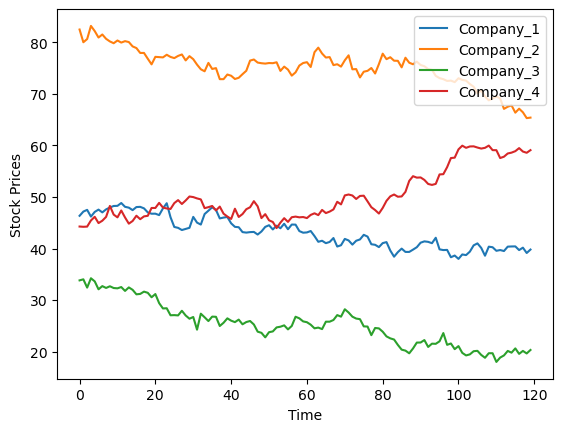

In [3]:
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.ylabel("Stock Prices")
plt.xlabel("Time")
plt.show()

## Define Terms

In [4]:
q = 1.0

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

## Classial Solution

In [5]:
def cost_func(x):
    return - np.sum(x * mu) + q * np.sum(np.outer(x, x) * sigma)

def bin_string_to_x(bin_string):
    return np.array([int(i) for i in bin_string])

def int_to_cost(i_sol):
    x = bin_string_to_x(np.binary_repr(i_sol, num_assets))
    return cost_func(x)

In [6]:
costs = [int_to_cost(i) for i in range(2**num_assets)]

for i in range(2**num_assets):
    print(f"{np.binary_repr(i, num_assets)} ({i}), {costs[i]}")

best_sol = np.argmin(costs)
print(f"\nBest solution: {best_sol}, ({costs[best_sol]})")

0000 (0), 0.0
0001 (1), -0.0022611607264786887
0010 (2), 0.004951878001374912
0011 (3), 0.0026667827704118727
0100 (4), 0.0020322131126270693
0101 (5), -0.00022872296360903902
0110 (6), 0.007018877148038772
0111 (7), 0.004734006567318312
1000 (8), 0.0014740701348145977
1001 (9), -0.0008654232200137587
1010 (10), 0.006640693049412961
1011 (11), 0.004277265190100254
1100 (12), 0.0034618119940834557
1101 (13), 0.0011225432894976799
1110 (14), 0.008663220942718609
1111 (15), 0.006300017733648481

Best solution: 1, (-0.0022611607264786887)


## Quantum Solution

To Solve on a QC, we change to $x_i=(1-z_i)/2$
$$
\begin{split}
C(\{z_i\}) &= -\frac{1}{2} \sum_i \mu_i + \frac{1}{2} \sum_i \mu_i z_i + \frac{1}{4}\sum_{ij} \sigma_{ij} - \frac{1}{4}\sum_{ij} \sigma_{ij} z_j  - \frac{1}{4}\sum_{ij} \sigma_{ij} z_i + \frac{1}{4}\sum_{ij} \sigma_{ij} z_i z_j \\
&= \frac{1}{4} \sum_i (\sigma_{ii}-2\mu_i) + \frac{1}{4}\sum_{ij} \sigma_{ij} + \frac{1}{4} \sum_i \left(2 \mu_i  - \sum_{j} \sigma_{ij} - \sum_{j} \sigma_{ji} \right) z_i + \frac{1}{4}\sum_{i \ne j} \sigma_{ij} z_i z_j  \\
&= \text{const} + \frac{1}{4}\left(\sum_i  c_i z_i + \sum_{i \ne j} \sigma_{ij} z_i z_j \right) \\
\end{split}
$$

Quantum Hamiltonian:
$$H = \sum_i  c_i Z_i + \sum_{i \ne j} \sigma_{ij} Z_i Z_j $$

In [7]:
c = 2*mu - sigma.sum(0) - sigma.sum(1)
const = - 0.5 * mu.sum() + 0.25 * sigma.sum() + 0.25 * sigma.trace()

In [8]:
# Construct Hamiltonian
operators = []
coefs = []

for i in range(num_assets):
    op = ['I'] * num_assets
    op[i] = 'Z'
    operators.append(Pauli(''.join(op)))
    coefs.append(c[i])
    
for i in range(num_assets-1):
    for j in range(i+1, num_assets):
        op = ['I'] * num_assets
        op[i] = 'Z'
        op[j] = 'Z'
        operators.append(Pauli(''.join(op)))
        coefs.append(sigma[i, j] + sigma[j, i])

hamiltonian = SparsePauliOp(operators, coefs)
hamiltonian

SparsePauliOp(['ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'],
              coeffs=[-3.04008130e-03+0.j, -4.05496566e-03+0.j, -1.01293524e-02+0.j,
  4.62436394e-03+0.j, -4.44712534e-05+0.j,  2.14744913e-04+0.j,
 -7.83326283e-05+0.j,  3.47860340e-05+0.j,  2.24650243e-07+0.j,
 -2.39345045e-05+0.j])

In [9]:
hq = const + 0.25*np.diag(hamiltonian.to_matrix())
assert np.allclose(hq, costs)

In [10]:
def create_ansatz():
    qc = QuantumCircuit(num_assets)
    
    for i in range(num_assets):
        qc.ry(Parameter(f'theta_{i}'), i)
    return qc

In [11]:
ansatz = create_ansatz()
ansatz.draw()

┌─────────────┐
q_0: ┤ Ry(theta_0) ├
     ├─────────────┤
q_1: ┤ Ry(theta_1) ├
     ├─────────────┤
q_2: ┤ Ry(theta_2) ├
     ├─────────────┤
q_3: ┤ Ry(theta_3) ├
     └─────────────┘

In [12]:
def compute_energy(params):
    """Return estimate of energy from estimator"""
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history.append(energy)
    print(f"Current cost: {energy}")

    return energy

In [13]:
estimator = StatevectorEstimator()

cost_history = []
x0 = 2 * np.pi * np.random.rand(num_assets)
res = minimize(compute_energy, x0, method="cobyla")

Current cost: 0.001885063613555502
Current cost: -0.001200351003082253
Current cost: -0.006953158720802007
Current cost: -0.007467573459033891
Current cost: -0.004877147753886297
Current cost: -0.00811840554041694
Current cost: -0.004769113116913248
Current cost: -0.008907329580012892
Current cost: -0.011836778304670288
Current cost: -0.013734692846179222
Current cost: -0.013221515926362873
Current cost: -0.014484277886419145
Current cost: -0.016253268818501712
Current cost: -0.01699160129580243
Current cost: -0.01867403912137839
Current cost: -0.018783700550861086
Current cost: -0.018568948167588445
Current cost: -0.020538466711461766
Current cost: -0.020705533685305613
Current cost: -0.02054893705345884
Current cost: -0.021446762416444682
Current cost: -0.020660640566121772
Current cost: -0.021283091432445
Current cost: -0.021461638378378684
Current cost: -0.021372016825512208
Current cost: -0.02111734589770902
Current cost: -0.021360924036996087
Current cost: -0.02148738197997493
Cu

In [14]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.02154166113525349
       x: [ 3.142e+00  6.283e+00  6.283e+00 -4.578e-05]
    nfev: 84
   maxcv: 0.0

In [15]:
sv = Statevector(ansatz.assign_parameters(res.x))
np.argmax(sv.probabilities())

1